# 🇬🇧 Practical: UK Demography, Sports, and Regression Modeling

This two-part practical explores the relationship between various demographic and economic characteristics of UK Local Authority Districts (LADs) and data about __sports engagement__. The sports engagement data originate from the UK Office for National Statistics; see https://www.ons.gov.uk/peoplepopulationandcommunity/wellbeing/datasets/sportsengagementbylocalauthoritydistrictladinengland. The dataset includes data on total minutes of exercise and sport club membership. Figures are provided for all inhabitants and separately for male and female.

We will transition from initial data exploration (Notebook 1) to iterative statistical modeling (Notebook 2), utilising techniques like residual analysis and model diagnostics to build a robust predictive regression model. The overall goal is to understand which variables are related to the sports enganement and to quantify the accuracy of our models.

## Notebook 1: Exploratory Data Analysis and Predictor Selection

__Objective__: To identify strong candidate predictors for a selected indicator of sports engagement using descriptive statistics and correlation analysis.

In this notebook, you will load and clean a previously prepared combined dataset, which contains LAD-level statistics on demographics (e.g., age, ethnicity, qualifications), economic deprivation, and tsports engagement.

You will use scatterplots and Pearson correlation coefficients to identify which demographic variables exhibit a strong, linear relationship with the chosen target indicator. The strongest variables identified here will serve as the starting predictors for the regression modeling in Notebook 2.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
# --- Define File Path and Load Data ---
# IMPORTANT: Ensure this CSV file is in the same folder as the Python script.
file_path = 'demography+sports_pct.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it is in the correct directory.")
    # Exit the script gracefully if the file isn't found
    exit()

### Initial data inspection

In [3]:
# --- Initial Data Inspection  ---
print("--- Initial Data Load ---")
print("First 5 rows of the dataset:")
print(df.head())
print("\nData types and missing values summary:")
df.info()

--- Initial Data Load ---
First 5 rows of the dataset:
          id                  Name  Age group=0-15: % by age  \
0  E06000001            Hartlepool                      19.1   
1  E06000002         Middlesbrough                      20.8   
2  E06000003  Redcar and Cleveland                      17.7   
3  E06000004      Stockton-on-Tees                      19.6   
4  E06000005            Darlington                      18.3   

   Age group=16-24: % by age  Age group=25-34: % by age  \
0                        9.9                       12.3   
1                       11.8                       14.3   
2                        8.9                       11.3   
3                        9.1                       12.7   
4                        9.2                       12.4   

   Age group=35-49: % by age  Age group=50-64: % by age  \
0                       17.3                       21.7   
1                       17.6                       18.6   
2                       16.7

### Explore correlations between the features
You need to know which features are highly correlated, either positively or negatively, to avoid including correlated features in the model. Using correlated, redundant features leads to overfitting and unnecessary complexity of the model.

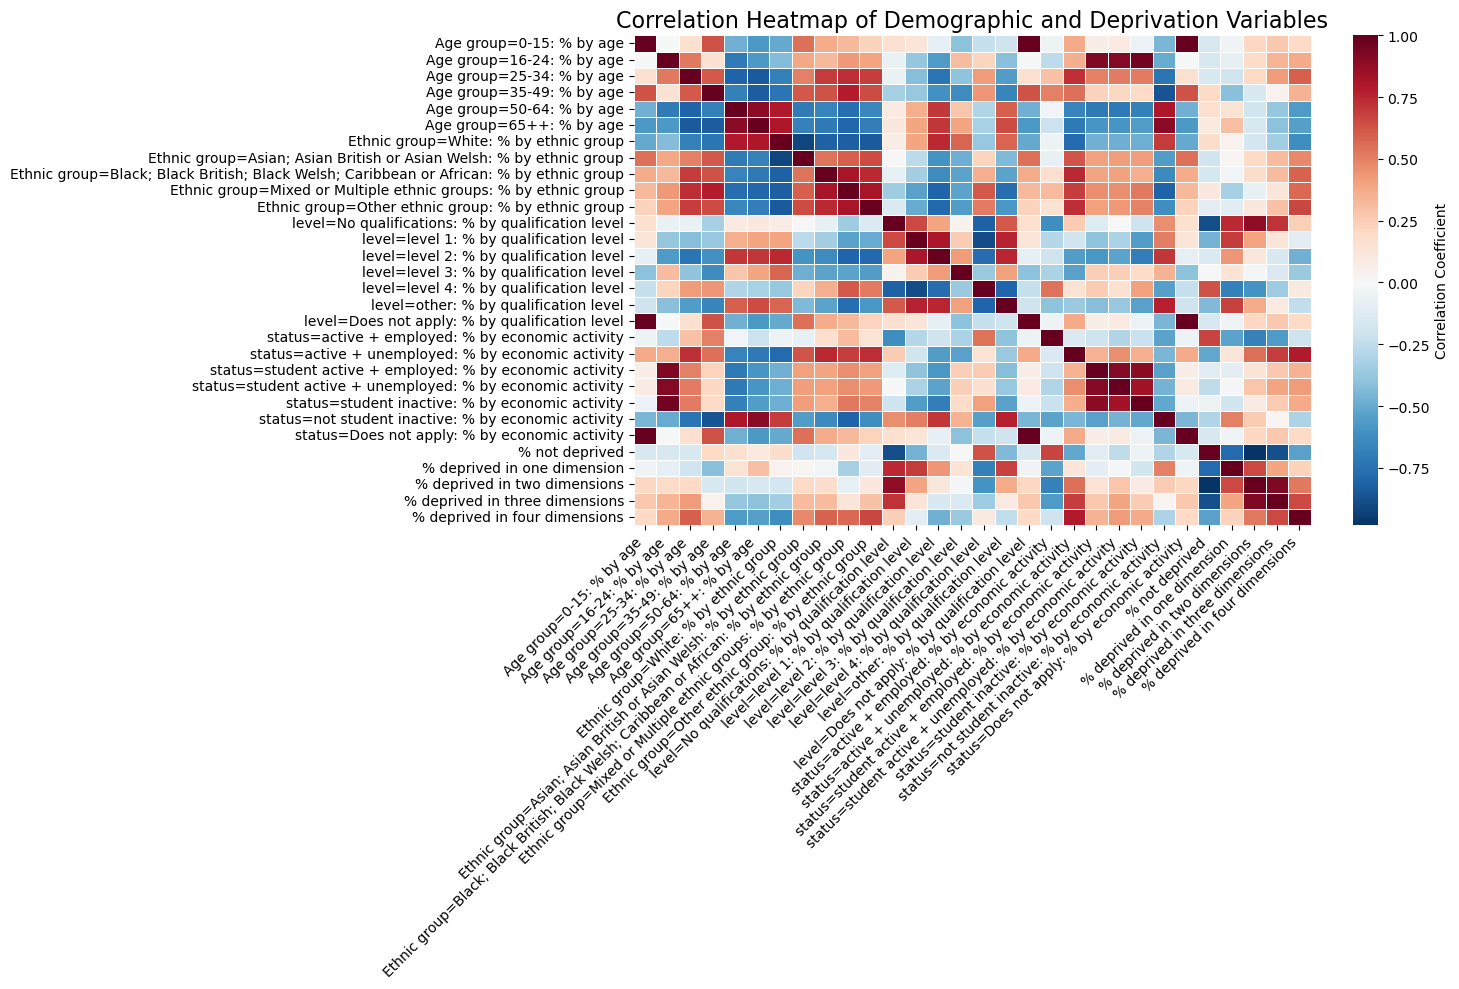

In [4]:
variables=df.loc[:,"Age group=0-15: % by age":"% deprived in four dimensions"]
corrMatrix = variables.corr()
fig = plt.figure(figsize=(15,10))

sns.heatmap(
    corrMatrix,
    #annot=True,       # Display the correlation values on the heatmap
    annot=False,       # <--- Set to False to omit the numbers
    #cmap='RdBu',       # Use 'RdBu' colormap (Red-Blue, diverging, red for negative, blue for positive)
    cmap='RdBu_r',     # REVERSED: Blue for negative, Red for positive
    center=0,         # Center the colormap at 0, making 0 white
    fmt=".2f",        # Format the annotations to 2 decimal places
    linewidths=.5,    # Add lines between cells for better visual separation
    cbar_kws={'label': 'Correlation Coefficient'} # Add a label to the color bar
)

plt.title('Correlation Heatmap of Demographic and Deprivation Variables', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.yticks(rotation=0)             # Keep y-axis labels horizontal
plt.tight_layout()                 # Adjust layout to prevent labels from overlapping
plt.show()

## Visualise correlations between the sports engagement variables
The correlation matrix may help you to choose an interesting target variable.

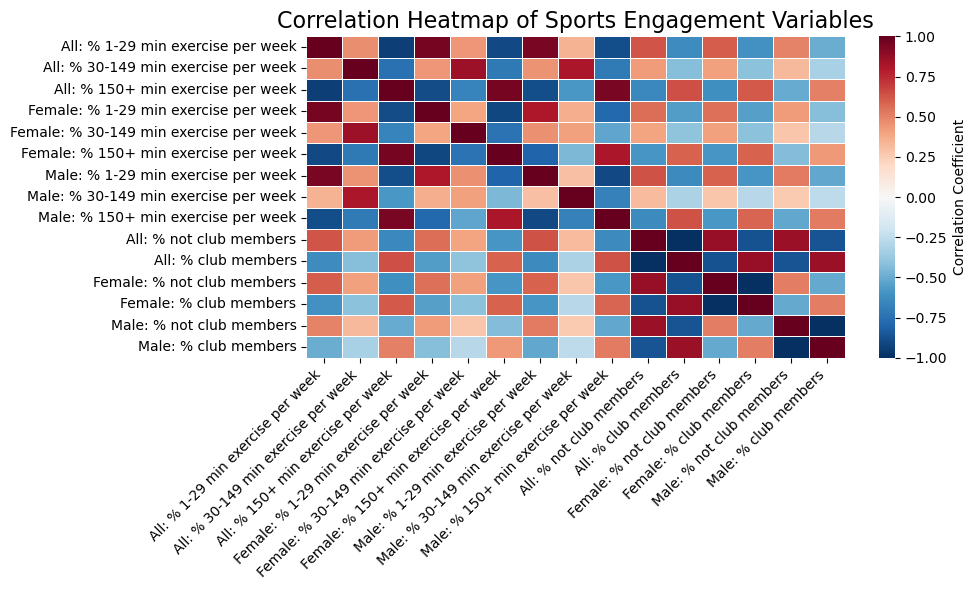

In [5]:
variables=df.loc[:,"All: % 1-29 min exercise per week":"Male: % club members"]
corrMatrix = variables.corr()
fig = plt.figure(figsize=(10,6))

sns.heatmap(
    corrMatrix,
    #annot=True,       # Display the correlation values on the heatmap
    annot=False,       # <--- Set to False to omit the numbers
    #cmap='RdBu',       # Use 'RdBu' colormap (Red-Blue, diverging, red for negative, blue for positive)
    cmap='RdBu_r',     # REVERSED: Blue for negative, Red for positive
    center=0,         # Center the colormap at 0, making 0 white
    fmt=".2f",        # Format the annotations to 2 decimal places
    linewidths=.5,    # Add lines between cells for better visual separation
    cbar_kws={'label': 'Correlation Coefficient'} # Add a label to the color bar
)

plt.title('Correlation Heatmap of Sports Engagement Variables', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.yticks(rotation=0)             # Keep y-axis labels horizontal
plt.tight_layout()                 # Adjust layout to prevent labels from overlapping
plt.show()

### Define the target variable and explore its relationships with the other variables to identify most relevant features for predicting the target value.

In [13]:
# --- Define Target and Candidate Predictors (Variables of Interest) ---

# The target variable can be switched to another indicator of sports engagement if desired.
TARGET_VAR = 'Female: % 150+ min exercise per week'

The following code defines a procedure that takes the target variable and a group of features (potential predictors) as arguments and creates for each feature a scatterplot of the feature values (X-axis) against the corresponding values of the target variable (Y-axis). Additionally, the scatterplot includes a linear regression line and the value of the Pearson's correlation coefficient.

In [7]:
def analyze_predictors(df, target_var, predictor_vars):
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import pearsonr

    # Select only the columns needed for the analysis (target + predictors).
    cols_to_use = [target_var] + predictor_vars
    df_analysis = df[cols_to_use].dropna()
    print(f"\nData used for plotting (after dropping NaNs): {len(df_analysis)} rows")

    n_plots = len(predictor_vars)
    n_cols = 2
    n_rows = int(np.ceil(n_plots / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    axes = axes.flatten() if n_plots > 1 else [axes]
    fig.suptitle(f'Visual Analysis: Candidate Predictors vs. {target_var} (LAD Level)', fontsize=16, y=1.02)

    for i, predictor in enumerate(predictor_vars):
        ax = axes[i]
        X = df_analysis[predictor]
        Y = df_analysis[target_var]
        r, p_value = pearsonr(X, Y)
        ax.scatter(X, Y, alpha=0.6, s=20)
        m, c = np.polyfit(X, Y, 1)
        line = np.poly1d([m, c])
        ax.plot(X, line(X), color='red', linestyle='--', label='Regression Line')
        title_label = predictor.split(':')[0].strip().replace('% by age', '').replace('% by qualification level', '').replace('% deprived in three dimensions', 'Deprived 3D').replace('% by ethnic group', '')
        ax.set_xlabel(title_label, fontsize=10)
        ax.set_ylabel(target_var, fontsize=10)
        ax.set_title(f'Feature: {title_label}', fontsize=12)
        text_r = f"Pearson's r: {r:.2f}"
        ax.text(0.95, 0.05, text_r, transform=ax.transAxes,
                fontsize=12, verticalalignment='bottom', horizontalalignment='right',
                bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.7, edgecolor='gray'))
    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    print(f"\nSuccessfully generated the figure for: {predictor_vars}")


Now use the earlier defined procedure analyze_predictors to explore the relationships of the available features to the target variable and identify the most relevant potential predictors of the target values.

### __Important__: 
#### When identifying relevance, pay attention not only at the correlation but also at the __point distribution along the X-axis__ and the presence of __outliers__. Sparsely populated intervals of feature values and/or presence of outliers make a feature poorly suited to serveing as a predictor.

#### __Age structure of the LAD populations (percentages of different age groups)__ 


Data used for plotting (after dropping NaNs): 307 rows


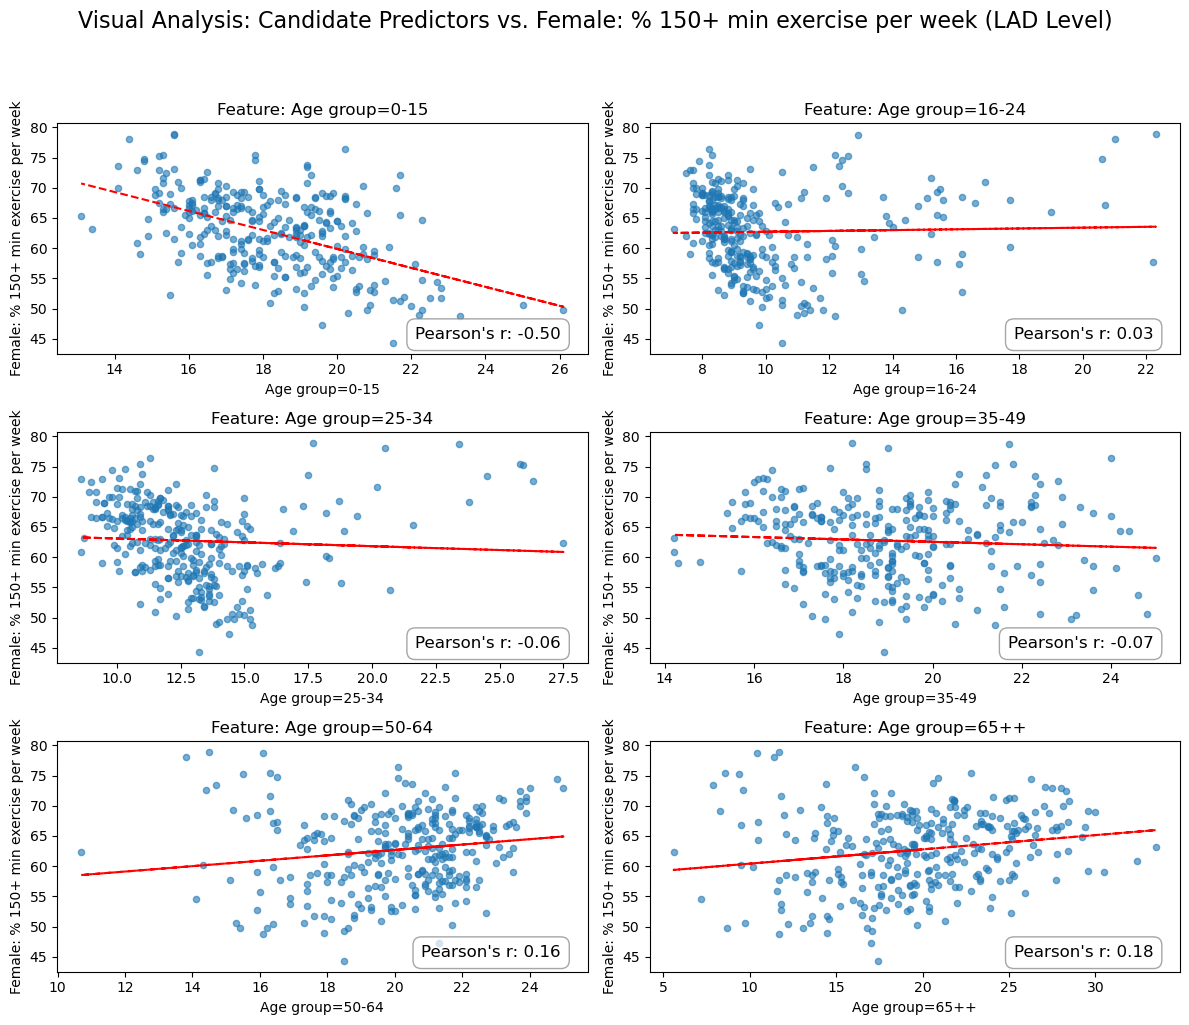


Successfully generated the figure for: ['Age group=0-15: % by age', 'Age group=16-24: % by age', 'Age group=25-34: % by age', 'Age group=35-49: % by age', 'Age group=50-64: % by age', 'Age group=65++: % by age']


In [8]:
# Age groups
age_predictors = [
    'Age group=0-15: % by age', 'Age group=16-24: % by age',
    'Age group=25-34: % by age', 'Age group=35-49: % by age',
    'Age group=50-64: % by age', 'Age group=65++: % by age'
]
analyze_predictors(df, TARGET_VAR, age_predictors)



#### __Ethnic structure of the district populations (percentages of different ethnic groups)__


Data used for plotting (after dropping NaNs): 307 rows


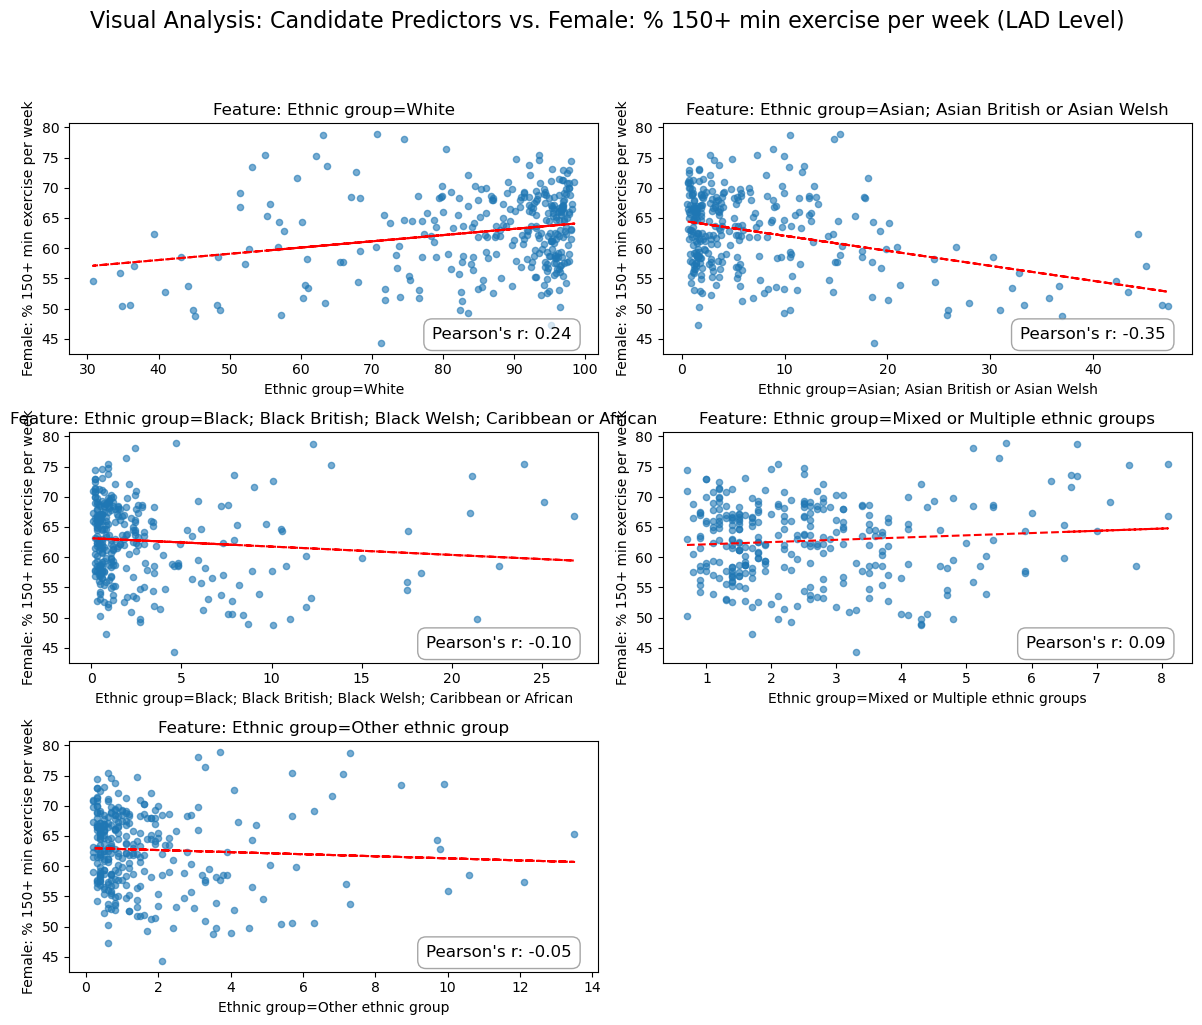


Successfully generated the figure for: ['Ethnic group=White: % by ethnic group', 'Ethnic group=Asian; Asian British or Asian Welsh: % by ethnic group', 'Ethnic group=Black; Black British; Black Welsh; Caribbean or African: % by ethnic group', 'Ethnic group=Mixed or Multiple ethnic groups: % by ethnic group', 'Ethnic group=Other ethnic group: % by ethnic group']


In [9]:
# Ethnic groups
ethnic_predictors = [
    'Ethnic group=White: % by ethnic group',
    'Ethnic group=Asian; Asian British or Asian Welsh: % by ethnic group',
    'Ethnic group=Black; Black British; Black Welsh; Caribbean or African: % by ethnic group',
    'Ethnic group=Mixed or Multiple ethnic groups: % by ethnic group',
    'Ethnic group=Other ethnic group: % by ethnic group'
]
analyze_predictors(df, TARGET_VAR, ethnic_predictors)


#### __Population proportions by qualification levels__

The variables for qualification levels (Level 1, Level 2, Level 3, Level 4) correspond to official UK government standards (the Regulated Qualifications Framework, or RQF). These levels are critical socioeconomic indicators, as higher levels of education are strongly associated with higher income. 

0. __No qualification__: No formal qualifications gained.
1. __Level 1__: A basic level of school achievement.
2. __Level 2__: The standard "passing" level of school achievement.
3. __Level 3__: The qualification you get before university.
4. __Level 4__: University degree and all qualifications beyond it. Includes Bachelor's Degree (BA/BSc), Master's Degree, or PhD.


Data used for plotting (after dropping NaNs): 307 rows


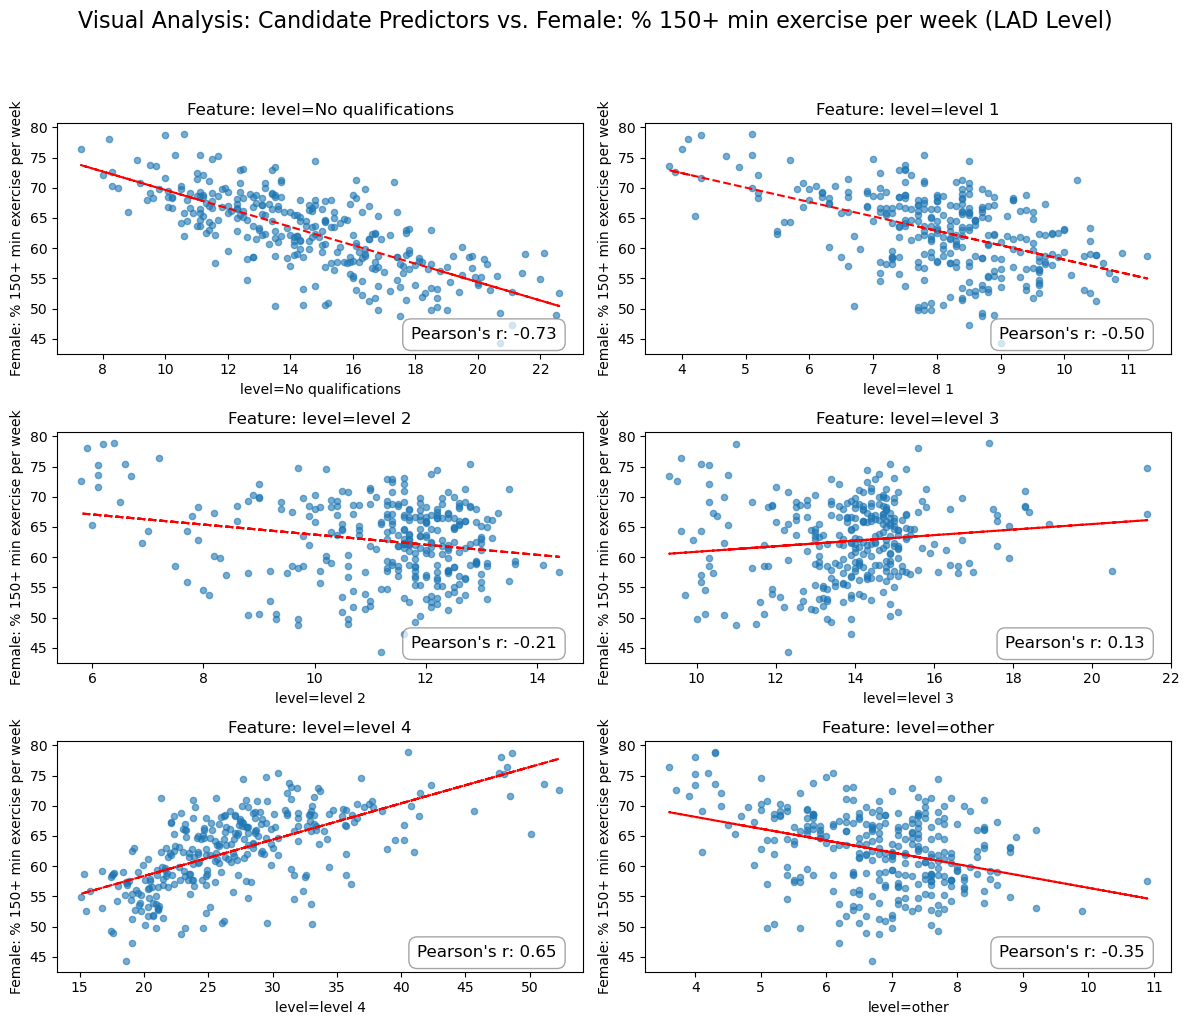


Successfully generated the figure for: ['level=No qualifications: % by qualification level', 'level=level 1: % by qualification level', 'level=level 2: % by qualification level', 'level=level 3: % by qualification level', 'level=level 4: % by qualification level', 'level=other: % by qualification level']


In [10]:
# Qualification levels
qualification_predictors = [
    'level=No qualifications: % by qualification level',
    'level=level 1: % by qualification level',
    'level=level 2: % by qualification level',
    'level=level 3: % by qualification level',
    'level=level 4: % by qualification level',
    'level=other: % by qualification level'#,
    #'level=Does not apply: % by qualification level' # - not interesting
]
analyze_predictors(df, TARGET_VAR, qualification_predictors)

#### __Proportions of population by economic activity status categories__

* __Active__ (Economically Active): Individuals who are either in employment or are actively seeking and available for employment.
* __Inactive__: Individuals who are neither in employment nor seeking or available for employment.
* __Active Student__: A student who is also working or actively looking for work.
* __Inactive__ (Retired, Sick, etc.): People who are inactive for reasons such as retired, looking after family, long-term sick/disabled.


Data used for plotting (after dropping NaNs): 307 rows


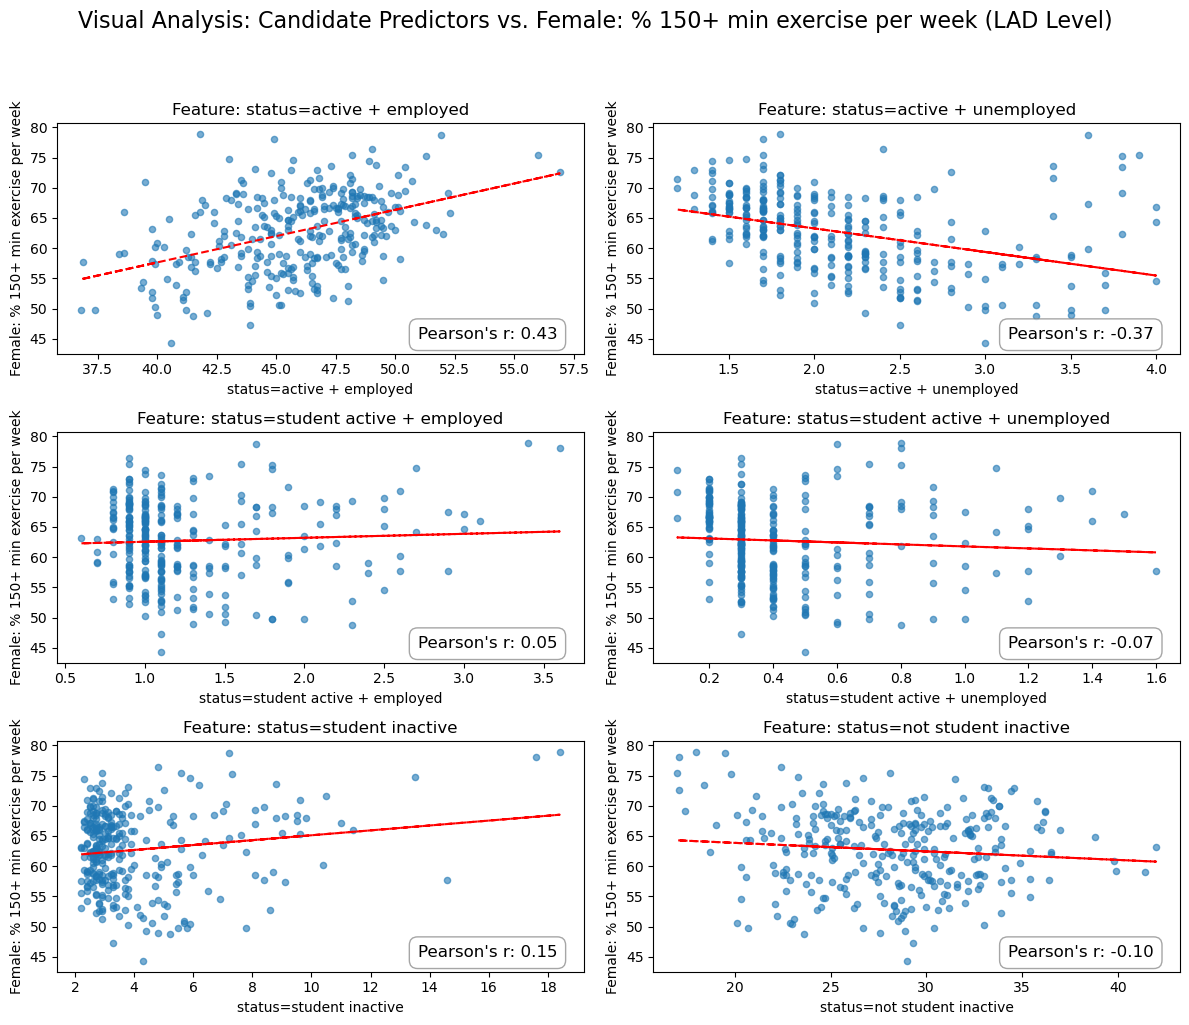


Successfully generated the figure for: ['status=active + employed: % by economic activity', 'status=active + unemployed: % by economic activity', 'status=student active + employed: % by economic activity', 'status=student active + unemployed: % by economic activity', 'status=student inactive: % by economic activity', 'status=not student inactive: % by economic activity']


In [11]:
# Economic activity
economic_predictors = [
    'status=active + employed: % by economic activity',
    'status=active + unemployed: % by economic activity',
    'status=student active + employed: % by economic activity',
    'status=student active + unemployed: % by economic activity',
    'status=student inactive: % by economic activity',
    'status=not student inactive: % by economic activity'#,
    #'status=Does not apply: % by economic activity' # - not interesting
]
analyze_predictors(df, TARGET_VAR, economic_predictors)


#### __Percentage of households by severity of deprivation__ (number of __dimensions__ in which a household is deprived)
#### __Deprivation dimensions__:  
* __Education__: A household is classified as deprived in the education dimension if no one has at least level 2 education and no one aged 16 to 18 years is a full-time student.
* _Employment_: A household is classified as deprived in the employment dimension if any member, not a full-time student, is either unemployed or economically inactive due to long-term sickness or disability.
* __Health__: A household is classified as deprived in the health dimension if any person in the household has general health that is bad or very bad or is identified as disabled. People who have assessed their day-to-day activities as limited by long-term physical or mental health conditions or illnesses are considered disabled. This definition of a disabled person meets the harmonised standard for measuring disability and is in line with the Equality Act (2010).
* __Housing__: A household is classified as deprived in the housing dimension if the household's accommodation is either overcrowded, in a shared dwelling, or has no central heating.

##### Please note that deprivation data are available for 307 districts out of 331.



Data used for plotting (after dropping NaNs): 290 rows


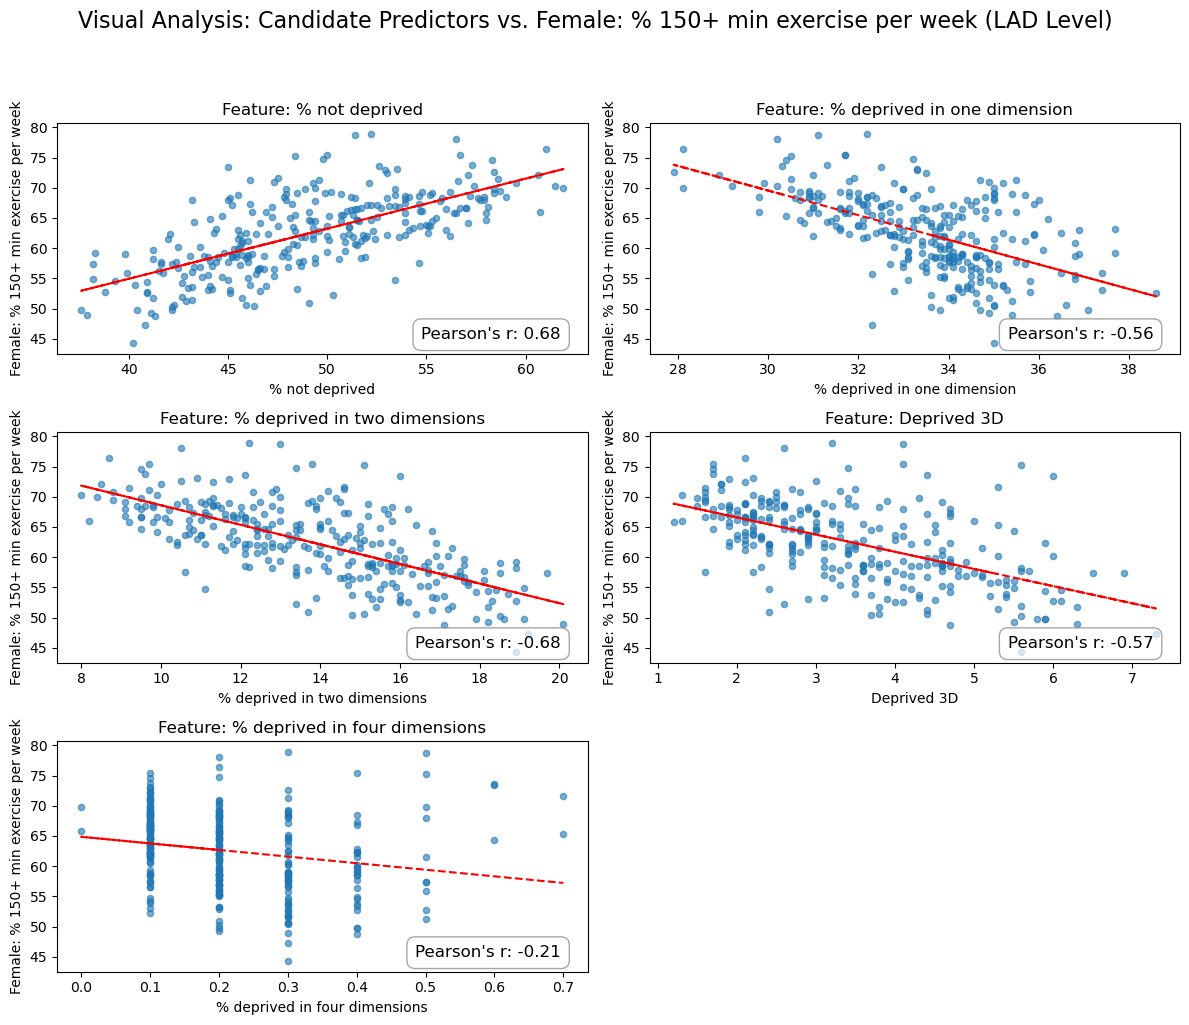


Successfully generated the figure for: ['% not deprived', '% deprived in one dimension', '% deprived in two dimensions', '% deprived in three dimensions', '% deprived in four dimensions']


In [12]:
# Deprivation severity
deprivation_predictors = [
    '% not deprived','% deprived in one dimension',
    '% deprived in two dimensions','% deprived in three dimensions',
    '% deprived in four dimensions'
]
analyze_predictors(df, TARGET_VAR, deprivation_predictors)

### Now you need to make a decision which of the available features to use first for creating a regression model predicting the values of the target variable.